Set your kernel using your python virtual environment from the tool bar: Kernel > Change kernel > \<your_kernel_name\>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

np.set_printoptions(precision=3, suppress=True)
tf.__version__

2023-09-20 16:29:47.332571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.13.0'

Now, we will prepare training and testing datasets

The first one is training dataset

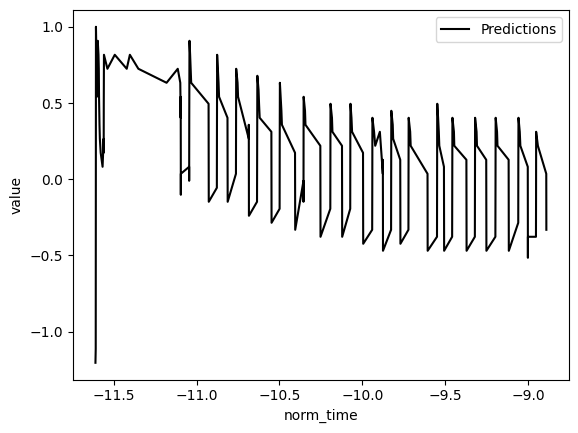

In [2]:
# Load grouped dataset
# We will train the ML model with dataset from station "1161114004" on the parameter "122"
grouped_dataset = pd.read_csv("./data_grouped/1161114004_122_.csv")

# Take data features with specific data type
grouped_dataset = grouped_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})

dataset = grouped_dataset.copy()

# Drop error/None data and unused features
dataset = dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
dataset_full = dataset.sort_values(by=['norm_time'])

# Plot first 300 data records
dataset = dataset_full[0:300]
plt.plot(dataset['norm_time'], dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('norm_time')
plt.ylabel('value')
plt.legend()
plt.show()

In [3]:
# Shift the data to creat a short time series (6 data points) for each record
serial_data = dataset.drop(['value','norm_time'], axis=1)
serial_data['norm_1'] = serial_data['norm_value'].shift(1)
serial_data['norm_2'] = serial_data['norm_value'].shift(2)
serial_data['norm_3'] = serial_data['norm_value'].shift(3)
serial_data['norm_4'] = serial_data['norm_value'].shift(4)
serial_data['norm_5'] = serial_data['norm_value'].shift(5)
serial_data['norm_6'] = serial_data['norm_value'].shift(6)
train_dataset = serial_data[6:]
train_dataset 

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,0.311370,0.632730,-0.055900,-0.423169,-0.790439,-1.111800,-1.203617
7,1.000000,0.311370,0.632730,-0.055900,-0.423169,-0.790439,-1.111800
8,0.908183,1.000000,0.311370,0.632730,-0.055900,-0.423169,-0.790439
9,0.816365,0.908183,1.000000,0.311370,0.632730,-0.055900,-0.423169
10,0.724548,0.816365,0.908183,1.000000,0.311370,0.632730,-0.055900
...,...,...,...,...,...,...,...
295,0.219552,0.311370,-0.009991,0.127735,-0.147717,-0.285443,-0.377261
296,0.035917,0.219552,0.311370,-0.009991,0.127735,-0.147717,-0.285443
297,-0.055900,0.035917,0.219552,0.311370,-0.009991,0.127735,-0.147717
298,-0.193626,-0.055900,0.035917,0.219552,0.311370,-0.009991,0.127735


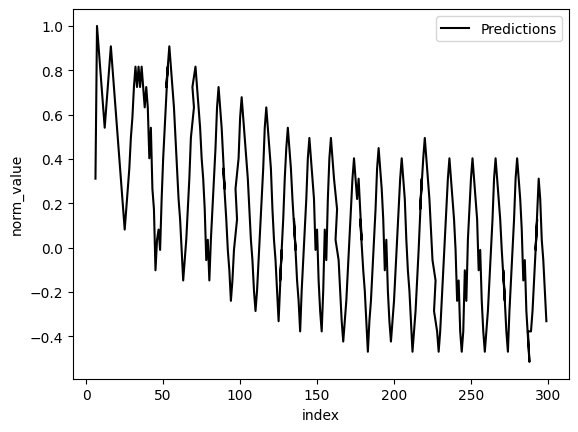

In [4]:
# Plot train data
plt.plot(train_dataset.index, train_dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('index')
plt.ylabel('norm_value')
plt.legend()
plt.show()

In [5]:
# Prepare train feature as numpy array befor feeding to ML model
# The normalized value would be the prediction lable so we will have to drop it here
train_features = np.array(train_dataset.drop(['norm_value'], axis=1))
train_features = np.array(train_features)[:,:,np.newaxis]
train_features.shape

(294, 6, 1)

In [6]:
# The lable for normalize value "6" would be the normalize value "5", (5<-4, 4<-3, 2<-1, 1<-norm_value)
# So norm_6 is not a lable for any other, then we drop norm_6 here
train_labels = np.array(train_dataset.drop(['norm_6'], axis=1))
train_labels = train_labels.reshape(train_labels.shape[0],train_labels.shape[1],1)
train_labels.shape

(294, 6, 1)

In [7]:
# We will test the trained ML model with data from station "1161114002" on the same parameter "122"
test_file_name = "./data_grouped/1161114002_122_.csv"
test_grouped_dataset = pd.read_csv(test_file_name)
test_grouped_dataset = test_grouped_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
test_dataset = test_grouped_dataset.copy()
test_dataset = test_dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
test_dataset_full = test_dataset.sort_values(by=['norm_time'])

# Get a part of the dataset for testing ML model
start_line = 0
end_line = 44
test_data = test_dataset_full[start_line:end_line]

In [8]:
# Similar to training dataset -> making a time series input for ML prediction
test_serial_data = test_data.drop(['value','norm_time'], axis=1)
test_serial_data['norm_1'] = test_serial_data['norm_value'].shift(1)
test_serial_data['norm_2'] = test_serial_data['norm_value'].shift(2)
test_serial_data['norm_3'] = test_serial_data['norm_value'].shift(3)
test_serial_data['norm_4'] = test_serial_data['norm_value'].shift(4)
test_serial_data['norm_5'] = test_serial_data['norm_value'].shift(5)
test_serial_data['norm_6'] = test_serial_data['norm_value'].shift(6)
test_dataset = test_serial_data[6:]
test_dataset

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.311759
7,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
8,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
9,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272
10,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110
11,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052
12,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110
13,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853
14,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016
15,-0.080272,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178


In [9]:
# The norm_value is the truth lable, so we drop it from the input
test_features = np.array(test_dataset.drop(['norm_value'], axis=1))
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
test_features.shape

(38, 6, 1)

In [10]:
test_dataset.drop(['norm_value'], axis=1)

,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.311759
7,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
8,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
9,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272
10,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110
11,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052
12,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110
13,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853
14,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016
15,-0.157435,-0.234597,-0.311759,-0.427503,-0.350340,-0.273178


In [11]:
np.array(test_dataset.drop(['norm_value'], axis=1))

array([[ 0.074, -0.003, -0.08 , -0.157, -0.235, -0.312],
       [-0.003,  0.074, -0.003, -0.08 , -0.157, -0.235],
       [-0.119, -0.003,  0.074, -0.003, -0.08 , -0.157],
       [-0.196, -0.119, -0.003,  0.074, -0.003, -0.08 ],
       [-0.273, -0.196, -0.119, -0.003,  0.074, -0.003],
       [-0.35 , -0.273, -0.196, -0.119, -0.003,  0.074],
       [-0.428, -0.35 , -0.273, -0.196, -0.119, -0.003],
       [-0.312, -0.428, -0.35 , -0.273, -0.196, -0.119],
       [-0.235, -0.312, -0.428, -0.35 , -0.273, -0.196],
       [-0.157, -0.235, -0.312, -0.428, -0.35 , -0.273],
       [-0.08 , -0.157, -0.235, -0.312, -0.428, -0.35 ],
       [-0.003, -0.08 , -0.157, -0.235, -0.312, -0.428],
       [ 0.074, -0.003, -0.08 , -0.157, -0.235, -0.312],
       [-0.003,  0.074, -0.003, -0.08 , -0.157, -0.235],
       [-0.08 , -0.003,  0.074, -0.003, -0.08 , -0.157],
       [-0.157, -0.08 , -0.003,  0.074, -0.003, -0.08 ],
       [-0.235, -0.157, -0.08 , -0.003,  0.074, -0.003],
       [-0.312, -0.235, -0.157,

In [12]:
# Only norm_6 is not a lable, so we drop norm_6
test_labels = np.array(test_dataset.drop(['norm_6'], axis=1))
test_labels = test_labels.reshape(test_labels.shape[0],test_labels.shape[1],1)
test_labels.shape

(38, 6, 1)

In [13]:
# Init the ML model
model = keras.Sequential()
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))

# Set the optimization for training
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.005))

# Training the model with training data
model.fit(train_features, train_labels, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
294/294 - 3s - loss: 0.0190 - 3s/epoch - 11ms/step
Epoch 2/100
294/294 - 1s - loss: 0.0101 - 674ms/epoch - 2ms/step
Epoch 3/100
294/294 - 1s - loss: 0.0070 - 663ms/epoch - 2ms/step
Epoch 4/100
294/294 - 1s - loss: 0.0051 - 674ms/epoch - 2ms/step
Epoch 5/100
294/294 - 1s - loss: 0.0055 - 666ms/epoch - 2ms/step
Epoch 6/100
294/294 - 1s - loss: 0.0055 - 662ms/epoch - 2ms/step
Epoch 7/100
294/294 - 1s - loss: 0.0044 - 671ms/epoch - 2ms/step
Epoch 8/100
294/294 - 1s - loss: 0.0043 - 664ms/epoch - 2ms/step
Epoch 9/100
294/294 - 1s - loss: 0.0041 - 662ms/epoch - 2ms/step
Epoch 10/100
294/294 - 1s - loss: 0.0045 - 668ms/epoch - 2ms/step
Epoch 11/100
294/294 - 1s - loss: 0.0048 - 672ms/epoch - 2ms/step
Epoch 12/100
294/294 - 1s - loss: 0.0044 - 664ms/epoch - 2ms/step
Epoch 13/100
294/294 - 1s - loss: 0.0045 - 666ms/epoch - 2ms/step
Epoch 14/100
294/294 - 1s - loss: 0.0043 - 666ms/epoch - 2ms/step
Epoch 15/100
294/294 - 1s - loss: 0.0044 - 668ms/epoch - 2ms/step
Epoch 16/100
294/294 

In [14]:
# Save model to file
model.save("BTS_LSTM_model")

INFO:tensorflow:Assets written to: BTS_LSTM_model/assets


INFO:tensorflow:Assets written to: BTS_LSTM_model/assets


MSE 0.007702954687927135


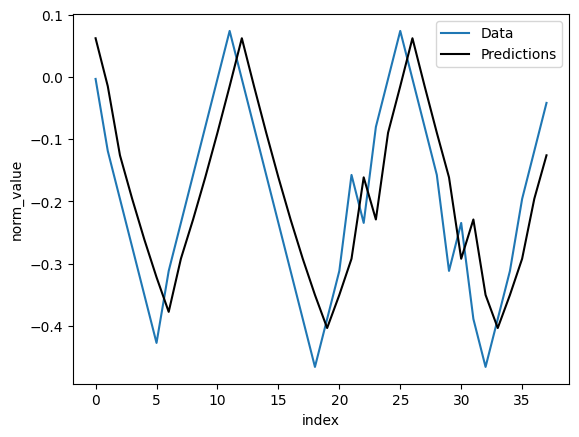

In [15]:

from sklearn.metrics import mean_squared_error

with mlflow.start_run():

    result = model.predict(test_features, batch_size=1, verbose=0)
    # print(result)
    x=pd.DataFrame(test_labels.reshape(test_labels.shape[0],test_labels.shape[1]))
    y=pd.DataFrame(result.reshape(result.shape[0],result.shape[1]))
    y_true = np.array(x[0])
    y_pred = np.array(y[0])

    mse = mean_squared_error(y_true, y_pred)
    print("MSE", mse)
    
    mlflow.log_metric("MSE",mse)
    mlflow.log_param("test line from ", '{} {}'.format(start_line, end_line))
    mlflow.log_param("Test file", test_file_name)
    plt.plot(x.index, x[0], label='Data')
    plt.plot(y.index, y[0], color='k', label='Predictions')
    plt.xlabel('index')
    plt.ylabel('norm_value')
    plt.legend()
    plt.savefig("BTS_resultGraph.png")
    mlflow.log_artifact("BTS_resultGraph.png")
    plt.show()
    plt.close()